## Using scMulan to annotate cell types in Heart, Lung, Liver, Bone marrow, Blood, Brain, and Thymus

In this study, the authors enrich the pre-training paradigm by integrating an abundance of metadata and a multiplicity of pre-training tasks, and obtain scMulan, a multitask generative pre-trained language model tailored for single-cell analysis. They represent a cell as a structured cell sentence (c-sentence) by encoding its gene expression, metadata terms, and target tasks as words of tuples, each consisting of entities and their corresponding values. They construct a unified generative framework to model the cell language on c-sentence and design three pretraining tasks to bridge the microscopic and macroscopic information within the c-sentences. They pre-train scMulan on 10 million single-cell transcriptomic data and their corresponding metadata, with 368 million parameters. As a single model, scMulan can accomplish tasks zero-shot for cell type annotation, batch integration, and conditional cell generation, guided by different task prompts.

#### we provide a liver dataset sampled (percentage of 20%) from Suo C, 2022 (doi/10.1126/science.abo0510)
**Paper:** [scMulan: a multitask generative pre-trained language model for single-cell analysis](https://www.biorxiv.org/content/10.1101/2024.01.25.577152v1)    
**Data download:** https://cloud.tsinghua.edu.cn/f/45a7fd2a27e543539f59/?dl=1   
**Pre-train model download:** https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1

If you found this tutorial helpful, please cite scMulan and OmicVerse:         
Bian H, Chen Y, Dong X, et al. scMulan: a multitask generative pre-trained language model for single-cell analysis[C]//International Conference on Research in Computational Molecular Biology. Cham: Springer Nature Switzerland, 2024: 479-482.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # if use CPU only
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')
!date
#import scMulan
#from scMulan import GeneSymbolUniform

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 14:43:18 CST


## 1. load h5ad
You can download the liver dataset from the following link: https://cloud.tsinghua.edu.cn/f/45a7fd2a27e543539f59/?dl=1 

It's recommended that you use h5ad here with raw count (and after your QC)


In [3]:
adata = sc.read('./data/liver_test.h5ad')
adata

AnnData object with n_obs × n_vars = 27436 × 43878
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'umap'

In [4]:
from scipy.sparse import csc_matrix
adata.X = csc_matrix(adata.X)

## 2. transform original h5ad with uniformed genes (42117 genes)

This step transform the genes in input adata to 42117 gene symbols and reserves the corresponding gene expression values. The gene symbols are the same as the pre-trained scMulan model.

In [5]:
adata_GS_uniformed = ov.external.scMulan.GeneSymbolUniform(input_adata=adata,
                                 output_dir="./data",
                                 output_prefix='liver')

{message}
The shape of query data is: (27436, 43878)
The length of reference gene_list is: 42117
Performing gene symbol uniform, this step may take several minutes


Processing: 100%|██████████| 43878/43878 [00:33<00:00, 1303.40it/s]


Building output data, this step may take several minutes


Processing: 100%|██████████| 42117/42117 [00:21<00:00, 1978.22it/s]


Shape of output data is (27436, 42117). It should have 42117 genes with cell number unchanged.
h5ad file saved in:/mnt/public/huf/ov_test/data/liver_uniformed.h5ad
report file saved in: /mnt/public/huf/ov_test/data/liver_report.csv


## 3. process uniformed data (simply norm and log1p)

In [6]:
## you can read the saved uniformed adata

adata_GS_uniformed=sc.read_h5ad('./data/liver_uniformed.h5ad')

In [7]:
adata_GS_uniformed

AnnData object with n_obs × n_vars = 27436 × 42117
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id'

In [8]:
# norm and log1p count matrix
# in some case, the count matrix is not normalized, and log1p is not applied.
# So we need to normalize the count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

## 4. load scMulan

In [9]:
# you should first download ckpt from https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1
# put it under .ckpt/ckpt_scMulan.pt
# by: wget https://cloud.tsinghua.edu.cn/f/2250c5df51034b2e9a85/?dl=1  -O ckpt/ckpt_scMulan.pt

ckp_path = './ckpt/ckpt_scMulan.pt'

In [10]:
scml = ov.external.scMulan.model_inference(ckp_path, adata_GS_uniformed)
base_process = scml.cuda_count()

number of parameters: 368.80M
✅ adata passed check
👸 scMulan is ready
scMulan is currently available to 2 GPUs.


In [11]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = 1)
# scml.get_cell_types_and_embds_for_adata(parallel=False) # for only using CPU, but it is really slow.

⚡ Speed up by multiprocessing with 1 processes and 2 GPUs...


⏳ Generating cell type labels and embds for each cell on device 0: 100%|██████████| 27436/27436 [42:06<00:00, 10.86it/s] 


The predicted cell types are stored in scml.adata.obs['cell_type_from_scMulan'], besides the cell embeddings (for multibatch integration) in scml.adata.obsm['X_scMulan'] (not used in this tutorial).

## 5. visualization

Here, we visualize the cell types predicted by scMulan. And we also visualize the original cell types in the dataset.

In [12]:
adata_mulan = scml.adata.copy()

In [13]:
# calculated the 2-D embedding of the adata using pyMDE
ov.pp.scale(adata_mulan)
ov.pp.pca(adata_mulan)

#sc.pl.pca_variance_ratio(adata_mulan)
ov.pp.mde(adata_mulan,embedding_dim=2,n_neighbors=15, basis='X_mde',
          n_pcs=10, use_rep='scaled|original|X_pca',)

computing PCA
    with n_comps=50
    finished (0:00:05)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsm['X_mde']`, MDE coordinates
    `.obsp['neighbors_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_connectivities']`, weighted adjacency matrix (0:00:21)


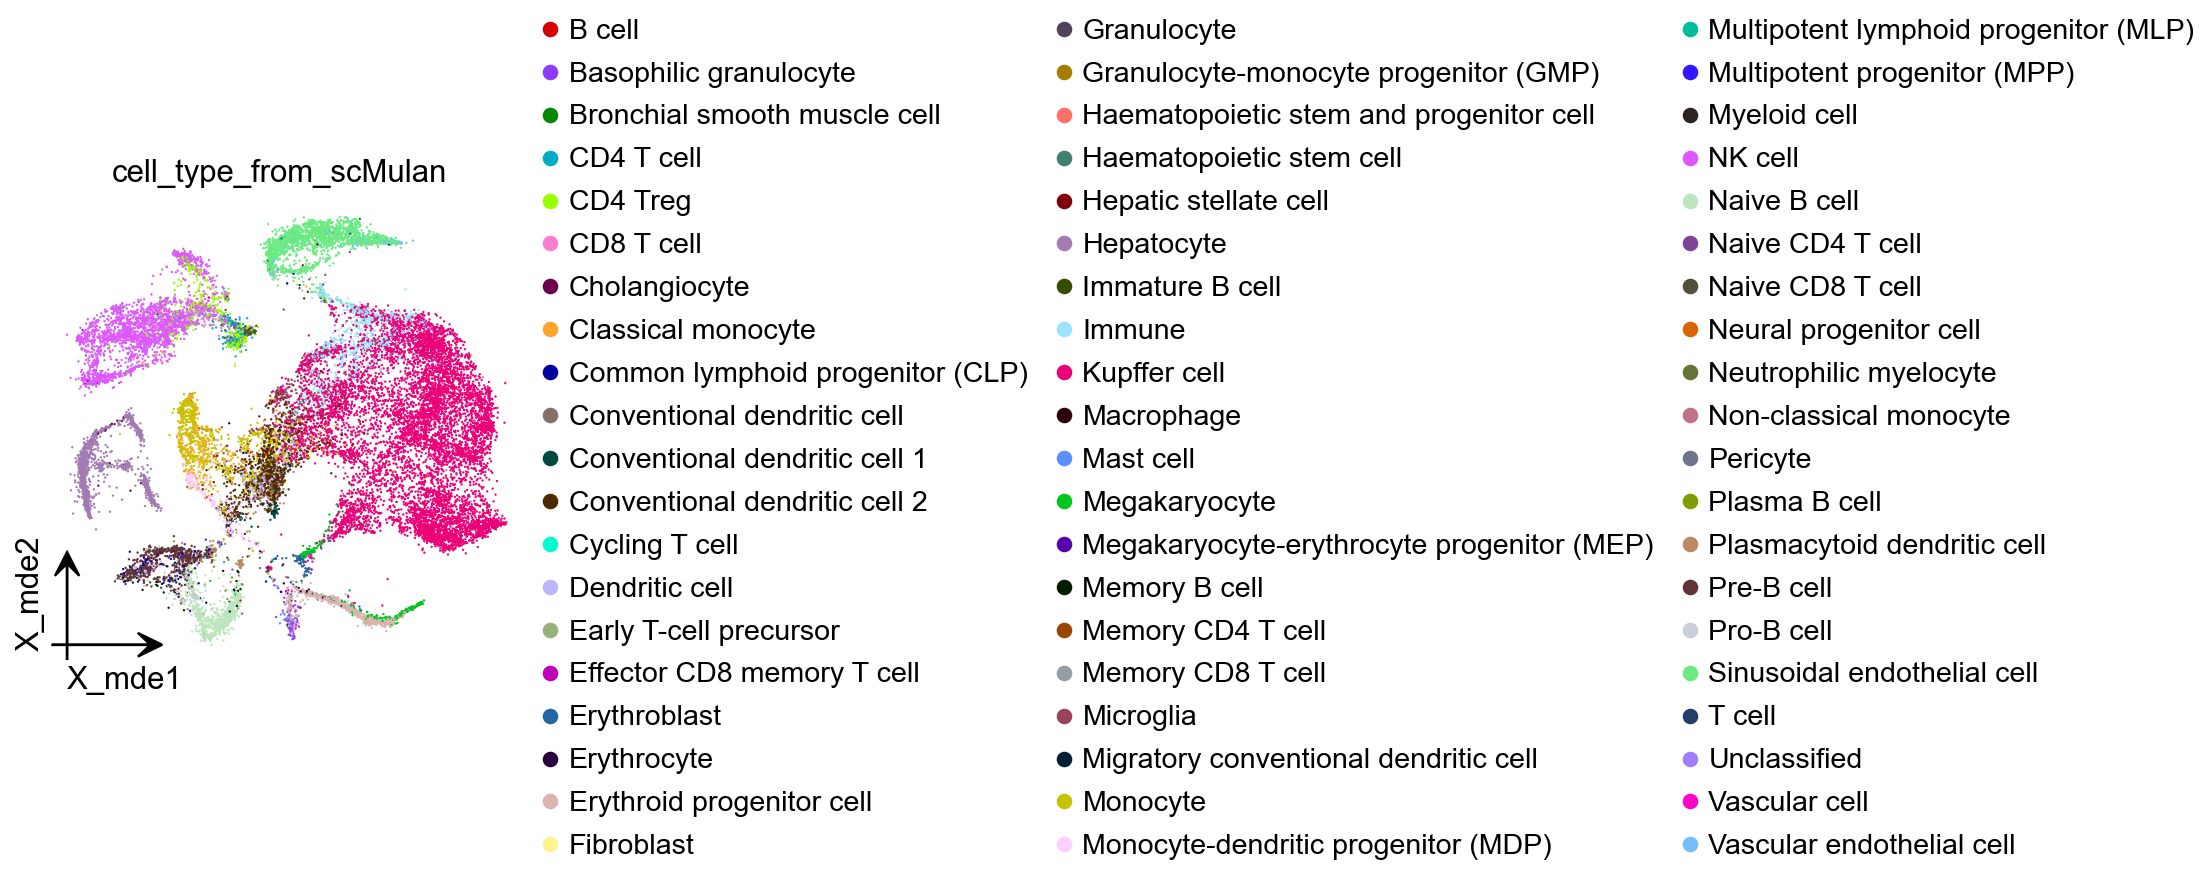

In [14]:
# Here, we can see the cell type annotation from scMulan
ov.pl.embedding(adata_mulan,basis='X_mde',
                color=["cell_type_from_scMulan",],
                ncols=1,frameon='small')

In [15]:
adata_mulan.obsm['X_umap']=adata_mulan.obsm['X_mde']

In [16]:
# you can run smoothing function to filter the false positives
ov.external.scMulan.cell_type_smoothing(adata_mulan, threshold=0.1)

computing neighbors


    finished: added to `.uns['Smoothing']`
    `.obsp['Smoothing_distances']`, distances for each pair of neighbors
    `.obsp['Smoothing_connectivities']`, weighted adjacency matrix (0:00:10)


100%|██████████| 27436/27436 [00:21<00:00, 1293.29it/s]


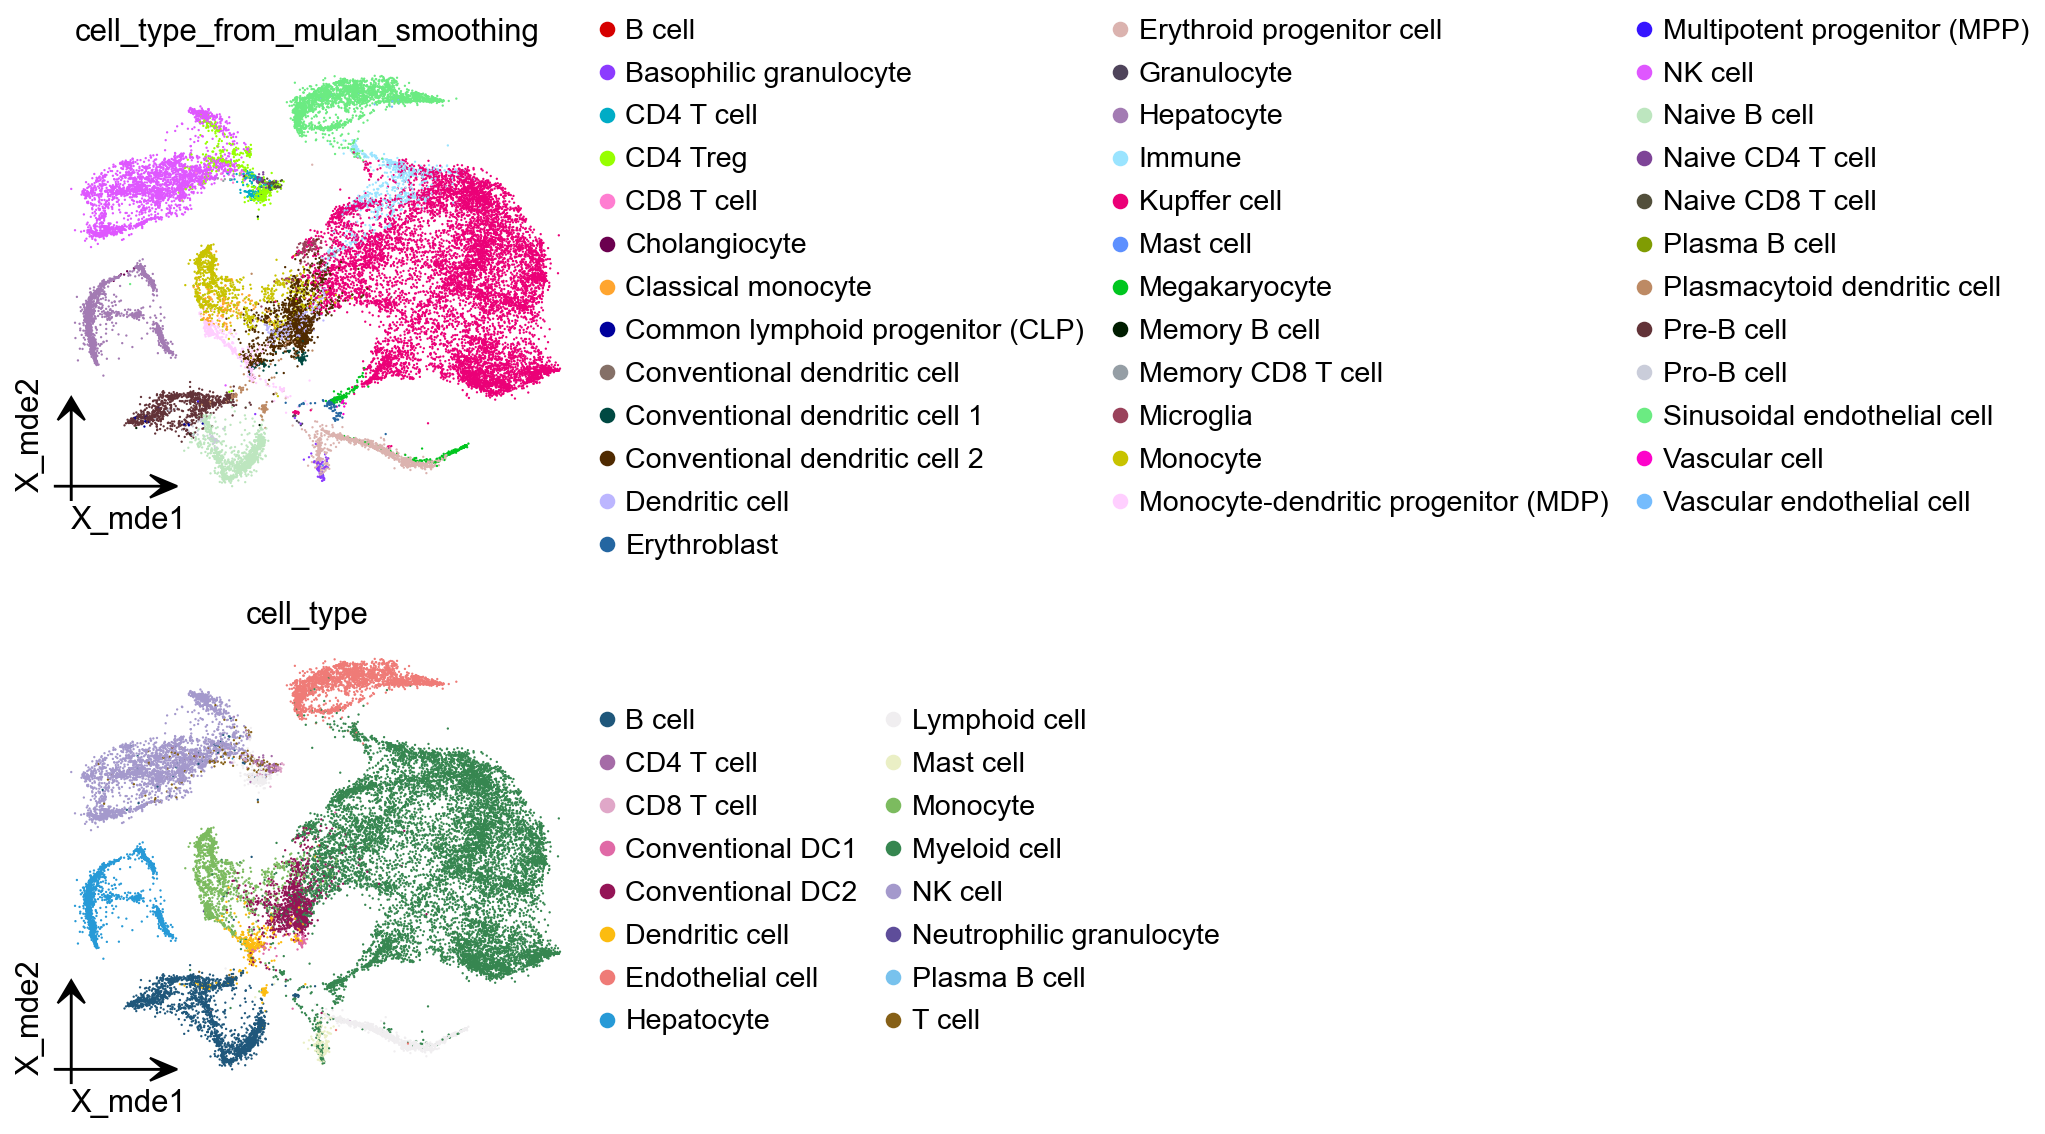

In [17]:
# cell_type_from_mulan_smoothing: pred+smoothing
# cell_type: original annotations by the authors
ov.pl.embedding(adata_mulan,basis='X_mde',
                color=["cell_type_from_mulan_smoothing","cell_type"],
                ncols=1,frameon='small')

In [18]:
adata_mulan

AnnData object with n_obs × n_vars = 27436 × 2000
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id', 'cell_type_from_scMulan', 'cell_type_from_mulan_smoothing', 'smoothing_score'
    uns: 'status', 'status_args', 'REFERENCE_MANU', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'cell_type_from_scMulan_colors', 'Smoothing', 'cell_type_from_mulan_smoothing_colors', 'cell_type_colors'
    obsm: 'X_scMulan', 'X_pca', 'scaled|original|X_pca', 'X_mde', 'X_umap'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'scaled'
    obsp: 'distances', 'connectivities', 'Smoothing_distances', 'Smoothing_connectivities'

In [19]:
top_celltypes = adata_mulan.obs.cell_type_from_scMulan.value_counts().index[:20]

selected_celltype
Kupffer cell                           9963
NK cell                                3029
Sinusoidal endothelial cell            2529
Hepatocyte                             2189
Conventional dendritic cell 2          1334
Erythroid progenitor cell              1234
Monocyte                               1111
Naive B cell                           1107
Pre-B cell                             1031
Immune                                  780
others                                  709
CD4 Treg                                645
Megakaryocyte                           500
Monocyte-dendritic progenitor (MDP)     418
Plasmacytoid dendritic cell             191
Dendritic cell                          173
CD4 T cell                              142
Classical monocyte                      135
Microglia                               124
Pro-B cell                               76
Memory CD8 T cell                        16
Name: count, dtype: int64


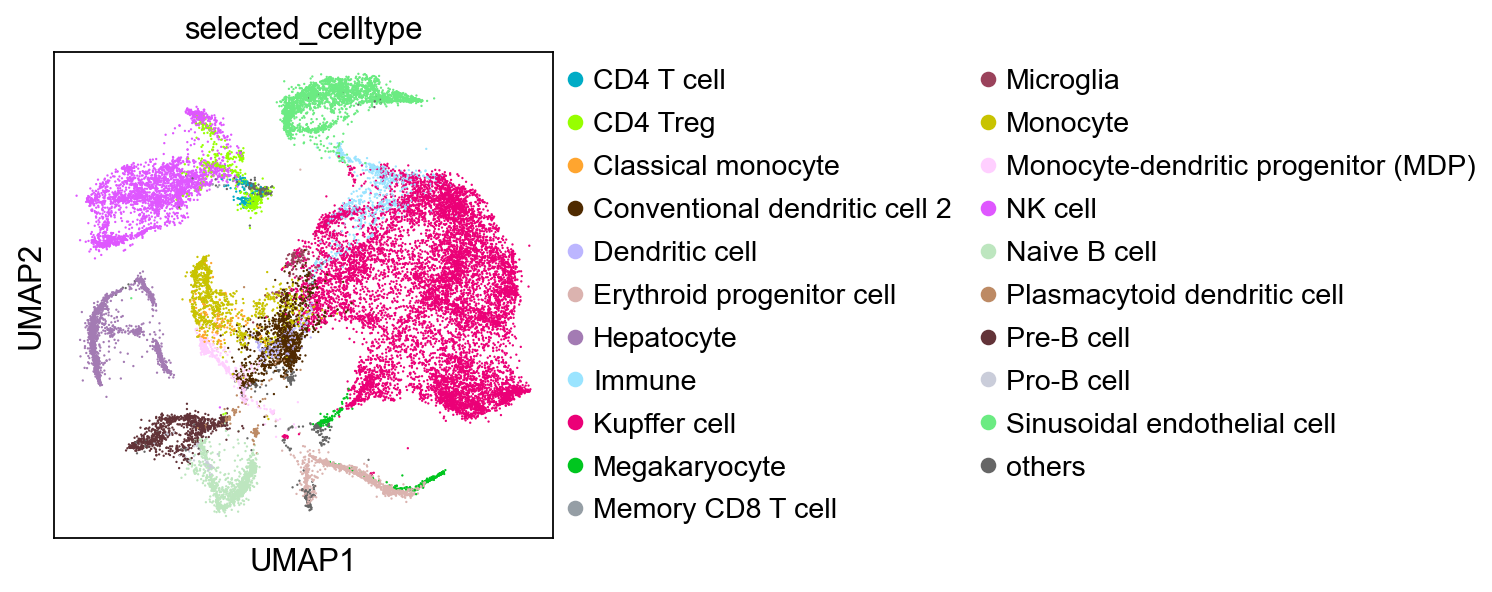

: 

In [ ]:
# you can select some cell types of interest (from scMulan's prediction) for visulization
# selected_cell_types = ["NK cell", "Kupffer cell", "Conventional dendritic cell 2"] # as example
selected_cell_types = top_celltypes
ov.external.scMulan.visualize_selected_cell_types(adata_mulan,selected_cell_types,smoothing=True)